# MGSC 404 Foundations of Decision Analytics - Fall 2021

# Case Study

## Team Members: (Put your names and email addresses here)

Note: If one student is from the other section, please specify that. 

## Section I: Introduction

(Briefly summarize the background, the goal and the findings of this case study.)

## Section II: Model 


**Assumptions**

Our model relies on the following assumptions:

1. American Office Systems, Inc. runs 2 work shifts of 8 hours every day for 20 days per month. Each quarter is made of 3 months therefore we made our full capacity the number of adapters for IBM and MAC produced each hour multiplied by the hours worked in a quarter. 
2. Forecasted sales are accurate 
3. We immediately pay the interest for borrowing in the previous quarter at the end of the following quarter 
4. Using a linear model is an appropriate approximation for an optimal strategy and further refinement will be done later. 
5. This model optimizes the accounting profit instead of the present and future cash flows of the operations. We opted for that sort of model because it depicts better the reality of the company and we found that, with the cash flow based models, the ending inventory of the last quarter was often too low to prepare for next year.


In [1]:
from gurobipy import *
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math

#### Step 1: Creating a Gurobi object

In [2]:
model = Model('case study')  

Academic license - for non-commercial use only - expires 2022-08-20
Using license file /Users/weiqi/gurobi.lic


#### Step 2: Defining Decision Variables

**Pi** = Production for IBM adapters in units of adapters, in quarters i, where i = 1,2,3,4             
**Pm** =  Production for MAC adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**Si** = Sales for IBM adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**Sm** = Sales for MAC adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**Mi** = Marketing for IBM adapters in units of additional adapter units sold due to marketing activities, in quarters i, where i = 1,2,3,4   
**Mm** = Marketing for MAC adapters in units of additional adapter units sold due to marketing activities, in quarters i, where i = 1,2,3,4  <br />
**B  =** Amount borrowed from the line of credit in units of dollars, in quarters i, where i = 1,2,3,4 <br />
**Ei** = Ending inventory for IBM adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**Em** = Ending inventory for MAC adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**CF** =Cash flow at the end of the quarter in units of dollars, in quarters i, where i = 1,2,3,4   


In [3]:
#initilizing empty dictionaries
Pi = {}  
Pm = {} 
Si = {} 
Sm = {} 
Mi = {} 
Mm = {} 
B = {} 
Ei = {}
Em = {} 
CF={}

# Create decisions variable
for i in np.arange(4):  
    Pi[i] = model.addVar(lb=0)
    Pm[i] = model.addVar(lb=0)
    Si[i] = model.addVar(lb=0)
    Sm[i] = model.addVar(lb=0)
    Mi[i] = model.addVar(lb=0)
    Mm[i] = model.addVar(lb=0)
    B[i] = model.addVar(lb=0)
    CF[i] = model.addVar(lb=0)
    Ei[i] = model.addVar(lb=0)
    Em[i] = model.addVar(lb=0)
    # By default Gurobi assumes that the lower bound of a variable lb=0, not minus infinity.

#### Step 3: Parameters

**price_ibm** = the selling price for IBM adapters  

**price_mac** = the selling price for MAC adapters  

**VC_ibm** =  the variable costs for IBM adapters 

**VC_mac** =  the variable costs for MAC adapters 

**beginning_inventory_ibm** =  the beginning inventory for IBM adapters at Q1  

**beginning_inventory_mac** =  the beginning inventory for MAC adapters at Q1 

**cost_advertising** =  the cost to sell one additional unit of either an IBM or MAC adapter  

**interest_rate_LOC** = The annual interest rate for the line of credit  

**fixed_costs** = The fixed costs per quarter   

**depreciation**= The quarterly depreciation costs 

**ibm_addition**= error forecast in production of IBM adapters 

**mac_addition**= error forecast in production of MAC adapters

In [1]:
# parameters  
price_ibm = 175
price_mac = 200
VC_ibm = 100
VC_mac = 110
beginning_inventory_ibm = 10000
beginning_inventory_mac = 5000
cost_advertising = 10
interest_rate_LOC = 0.16
interest_rate_bonds = 0.06
fixed_costs = 150000
depreciation = 400000

#### Step 4: Constraints

**Production IBM Constraints:** We included production constraints on IBM adapters of 28800 units for the first three quarters, since our calculation assumed two shifts of 8 hours a day, 20 days a month, 3 months a quarter, and 30 adapters per hour. Our last quarter has a production constraint of 31680 as that accounts for the 10% increase in capacity by the beginning of the first quarter.   
  
**Production MAC Constraints:** We included production constraints on MAC adapters of 9600 units for the first three quarters, since our calculation assumed two shifts of 8 hours a day, 20 days a month, 3 months a quarter, and 10 adapters per hour. Our last quarter has a production constraint of 10560 as that accounts for the 10% increase in capacity by the beginning of the first quarter. 

**Cash Flow Constraints:** We included constraints to define our cash flows appropriately. The first element is borrowing, where we ensure that borrowing was equal to the amount borrowed this quarter subtract the amount borrowed the previous quarter. This ensures that borrowing will never be above the $750,000k limit and leaves the flexibility for the company to vary their amount borrowed month to month as a line of credit acts as a pseudo chequing account. Following, we have the revenue from IBM and MAC sales, which are calculated using the selling price, and keeping in mind the collection percentages per quarter. After that we remove variable costs, marketing costs, the interest rate from the amount borrowed the previous quarter (see assumptions), and finally the fixed costs. Some of these are not applicable for the initial cash flow, as there has been no costs associated with borrowing yet. 

**Please add descriptions of other constraints yourself..**

In [5]:
# production ibm constraint
con_production_ibm={}
con_production_ibm[0]= model.addConstr(Pi[0]<=28800)
con_production_ibm[1]= model.addConstr(Pi[1]<=28800)
con_production_ibm[2]= model.addConstr(Pi[2]<=28800)
con_production_ibm[3]= model.addConstr(Pi[3]<=31680)

# production mac constraint
con_production_mac={}
con_production_mac[0]=model.addConstr(Pm[0]<=9600)
con_production_mac[1]=model.addConstr(Pm[1]<=9600)
con_production_mac[2]=model.addConstr(Pm[2]<=9600)
con_production_mac[3]=model.addConstr(Pm[3]<=10560)

# inventory management constraint ibm
estimated_sale_ibm={}
estimated_sale_ibm[0]=model.addConstr(Pi[0] + Ei[0] >= 1.1*Si[1])
estimated_sale_ibm[1]= model.addConstr(Pi[1] +Ei[1] >= 1.1*Si[2])
estimated_sale_ibm[2]= model.addConstr(Pi[2] +Ei[2] >= 1.1*Si[3])

# ending inventory ibm 
ending_inventory_ibm={}
ending_inventory_ibm[0]=model.addConstr(Ei[0] == beginning_inventory_ibm + Pi[0] - Si[0])
ending_inventory_ibm[1]=model.addConstr(Ei[1] == Ei[0] + Pi[1] - Si[1])
ending_inventory_ibm[2]=model.addConstr(Ei[2] == Ei[1] + Pi[2] - Si[2])
ending_inventory_ibm[3]=model.addConstr(Ei[3] == Ei[2] + Pi[3] - Si[3])


#ending inventory mac
ending_inventory_mac={}
ending_inventory_mac[0]= model.addConstr(Em[0] == beginning_inventory_mac + Pm[0] - Sm[0])
ending_inventory_mac[1]= model.addConstr(Em[1] == Em[0] + Pm[1] - Sm[1])
ending_inventory_mac[2]= model.addConstr(Em[2] == Em[1] + Pm[2] - Sm[2])
ending_inventory_mac[3]= model.addConstr(Em[3] == Em[2] + Pm[3] - Sm[3])


# cash flow
cash_flow={}
cash_flow[0]= model.addConstr(CF[0] == (B[0] 
                                        + price_ibm*(0.75*Si[0] + 0.20*8000 + 0.03*7000 + 0.02*7000*0.5) 
                                        + price_mac*(0.80*Sm[0] + 0.11*1600 + 0.05*1400 + 0.04*1400*0.5) 
                                        - (VC_ibm*Pi[0] + cost_advertising*Mi[0]) 
                                        - (VC_mac*Pm[0] + cost_advertising*Mm[0]) 
                                        - fixed_costs))
cash_flow[1]=model.addConstr(CF[1] == ((B[1]-B[0]) 
                                       + price_ibm*(0.75*Si[1] + 0.20*Si[0] + 0.03*8000 + 0.02*8000*0.5) 
                                       + price_mac*(0.80*Sm[1] + 0.11*Sm[0] + 0.05*1600 + 0.04*1600*0.5) 
                                       - (VC_ibm*Pi[1] + cost_advertising*Mi[1]) 
                                       - (VC_mac*Pm[1] + cost_advertising*Mm[1]) 
                                       - B[0]*((1+interest_rate_LOC)**(0.25)-1) 
                                       - fixed_costs))
cash_flow[2]=model.addConstr(CF[2] == ((B[2]-B[1]) 
                                       + price_ibm*(0.75*Si[2] + 0.20*Si[1] + 0.03*Si[0] + 0.02*Si[0]*0.5) 
                                       + price_mac*(0.80*Sm[2] + 0.11*Sm[1] + 0.05*Sm[0] + 0.04*Sm[0]*0.5) 
                                       - (VC_ibm*Pi[2] + cost_advertising*Mi[2]) 
                                       - (VC_mac*Pm[2] + cost_advertising*Mm[2]) 
                                       - B[1]*((1+interest_rate_LOC)**(0.25)-1) 
                                       - fixed_costs))
cash_flow[3]=model.addConstr(CF[3] == ((B[3]-B[2]) 
                                       + price_ibm*(0.75*Si[3] + 0.20*Si[2] + 0.03*Si[1] + 0.02*Si[1]*0.5) 
                                       + price_mac*(0.80*Sm[3] + 0.11*Sm[2] + 0.05*Sm[1] + 0.04*Sm[1]*0.5) 
                                       - (VC_ibm*Pi[3] + cost_advertising*Mi[3])
                                       - (VC_mac*Pm[3] + cost_advertising*Mm[3]) 
                                       - B[2]*((1+interest_rate_LOC)**(0.25)-1) 
                                       - fixed_costs))



**Objective Function**

$$\max\sum_{i\in\{0,1,2,3\}}\bigg((P_{i_i}*S_{i_i})+(P_{m_i}*S_{m_i})-(VC_{ibm}*S_{i_i})-(VC_{mac}*S_{m_i}) \bigg)$$


**Please add some explanations for your objective fuction..**

In [6]:
# objective function
obj = (price_ibm*Si[0]+price_mac*Sm[0]-VC_ibm*Si[0]-VC_mac*Sm[0] 
       + price_ibm*Si[1]+price_mac*Sm[1]-VC_ibm*Si[1]-VC_mac*Sm[1]
       + price_ibm*Si[2]+price_mac*Sm[2]-VC_ibm*Si[2]-VC_mac*Sm[2]
       + price_ibm*Si[3]+price_mac*Sm[3]-VC_ibm*Si[3]-VC_mac*Sm[3])
       
        
model.setObjective(obj, GRB.MAXIMIZE)

In [7]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 23 rows, 40 columns and 92 nonzeros
Model fingerprint: 0xba6420e9
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [8e+01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 2e+05]
Presolve removed 17 rows and 32 columns
Presolve time: 0.00s
Presolved: 6 rows, 8 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5718873e+07   3.609015e+04   0.000000e+00      0s
      10    1.3166562e+07   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.01 seconds
Optimal objective  1.316656228e+07


### Optimal Solution

In [8]:
base_model=model.ObjVal
print("The optimal solution will result in a profit of:", "$",model.objVal, "at the end of Q4 1996") 

The optimal solution will result in a profit of: $ 13166562.283996994 at the end of Q4 1996


In [11]:
print("Here is a table containing key summary information regarding the optimal solution:")
Solution = Table().with_columns([
     'Quarters',[1,2,3,4],
    'Production IBM',[Pi[0].x, Pi[1].x,Pi[2].x,Pi[3].x],
    'Production Mac',[Pm[0].x, Pm[1].x,Pm[2].x,Pm[3].x],    
    ])
Solution

Here is a table containing key summary information regarding the optimal solution:


Quarters,Production IBM,Production Mac
1,28800,9600
2,28800,9600
3,28800,9600
4,31680,10560


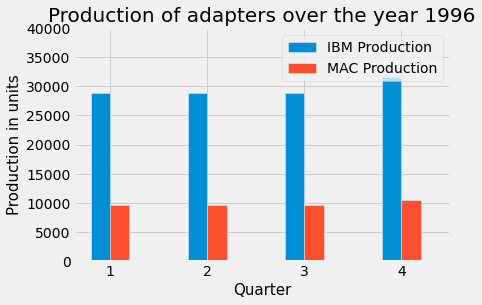

In [12]:
plots.bar(Solution.column("Quarters")-0.1,Solution.column("Production IBM"),width=0.2,label="IBM Production")
plots.bar(Solution.column("Quarters")+0.1,Solution.column("Production Mac"),width=0.2,label="MAC Production")
plots.xticks([1,2,3,4])
plots.axis(xmax=4.5,ymax=40000)
plots.xlabel("Quarter",fontsize=15)
plots.ylabel("Production in units",fontsize=15)
plots.title("Production of adapters over the year 1996",fontsize=20)
_ =plots.legend(loc="upper right")

### Key findings from the optimal solution:

...

## Section III: Sensitivity Analysis

 (Answer Questions 5, 8, 9 in the case)

## Section IV: Original Sensitivity Analysis

(Present two original sensitivity analysis of your interest such as what if some of the data is changed, etc.)

## Section V: Conclusion

(Briefly conclude the report.)

## Author Contributions

Trudeau and Legault formulated the LP. Putin coded and solved the LP. Trudeau and Putin prepared the report. Putin and Legault conducted sensitivity analysis...
